In [1]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 763.4/763.4 kB 5.2 MB/s eta 0:00:00


In [2]:
import typing
import collections

import tqdm
import torch
import numpy
import scipy
import torchvision
import torchmetrics
import sklearn.metrics
import sklearn.model_selection
import matplotlib.pyplot as plt

TRAIN_SIZE = 5000
VAL_SIZE = 500
TEST_SIZE = 10000

RANDOM_STATE = 42
GENERATOR = torch.manual_seed(RANDOM_STATE)

CV_FOLDS = 3
PARAMS = {
    'k': [ 1, 5, 9, 11, 13, 15, 25 ],
    'metric': [ 'hamming', 'cityblock', 'chebyshev', 'sqeuclidean' ]
}

PLOT_K = [ 2 * i + 1 for i in range(0, 50) ]

# Load the data

You can download CIFAR10 dataset from official site:

https://www.cs.toronto.edu/~kriz/cifar.html

or do it using Pytorch:
https://pytorch.org/vision/stable/datasets.html#cifar

or another framework.



In [3]:
train_dataset = torchvision.datasets.CIFAR10(
    'cifar-10',
    train = True,
    download = True,
    transform = torchvision.transforms.ToTensor()
)
test_dataset = torchvision.datasets.CIFAR10(
    'cifar-10',
    train = False,
    download = True,
    transform = torchvision.transforms.ToTensor()
)
print(train_dataset)
print(test_dataset)

# classes = ['Самолет', 'Автомобиль', 'Птица', 'Кошка', 'Олень', 'Собака', 'Лягушка', 'Лошадь', 'Корабль', 'Грузовик']
classes = test_dataset.classes
print(classes)

100%|██████████| 170498071/170498071 [00:02<00:00, 73875216.71it/s]


Extracting cifar-10/cifar-10-python.tar.gz to cifar-10
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar-10
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar-10
    Split: Test
    StandardTransform
Transform: ToTensor()
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Split data into train and validation parts

Extract subset containing train and validation parts.
Part must contain 5000 and 500 samples respectively.

In [4]:
train_sizes = [ TRAIN_SIZE, VAL_SIZE, len(train_dataset) - TRAIN_SIZE - VAL_SIZE ]
test_sizes = [ TEST_SIZE, len(test_dataset) - TEST_SIZE ]

train, val, _ = torch.utils.data.random_split(train_dataset, train_sizes, GENERATOR)
test, _ = torch.utils.data.random_split(test_dataset, test_sizes, GENERATOR)

assert len(train) == TRAIN_SIZE
assert len(val) == VAL_SIZE
assert len(test) == TEST_SIZE

print('Train: {}'.format(len(train)))
print('Validation: {}'.format(len(val)))
print('Test: {}'.format(len(test)))

Train: 5000
Validation: 500
Test: 10000


In [5]:
def xy_split(dataset: torch.utils.data.Dataset) -> typing.Tuple[torch.Tensor, numpy.array]:
    x, y = next(iter(torch.utils.data.DataLoader(dataset, batch_size = len(dataset))))
    return x, numpy.array(y)

X_train, y_train = xy_split(train)
X_val, y_val = xy_split(val)
X_test, y_test = xy_split(test)

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)
assert len(X_test) == len(y_test)

print('Train: {}, {}'.format(X_train.shape, y_train.shape))
print('Validation: {}, {}'.format(X_val.shape, y_val.shape))
print('Test: {}, {}'.format(X_test.shape, y_test.shape))

Train: torch.Size([5000, 3, 32, 32]), (5000,)
Validation: torch.Size([500, 3, 32, 32]), (500,)
Test: torch.Size([10000, 3, 32, 32]), (10000,)


## Dispaly some images  along with it class names
  


frog (6), deer (4), horse (7)


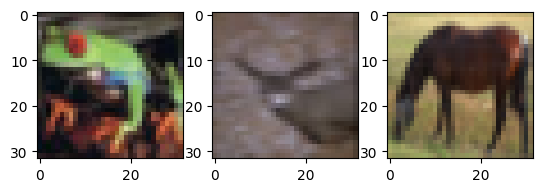

In [6]:
figure, axes = plt.subplots(1, 3)
axes[0].imshow(X_train[0].permute(1, 2, 0))
axes[1].imshow(X_val[0].permute(1, 2, 0))
axes[2].imshow(X_test[0].permute(1, 2, 0))
print(
    '{} ({}), {} ({}), {} ({})'.format(
        classes[y_train[0]], y_train[0],
        classes[y_val[0]], y_val[0],
        classes[y_test[0]], y_test[0]
    )
)

# Implement NearestNeighbor class

In [7]:
class kNearestNeighbors:
    def __init__(self, *args, **params):
        self.set_params(*args, **params)

    def set_params(self, k: int = 1, metric: str = 'cityblock'):
        self.k = k
        self.metric = metric
        return self

    def get_params(self, deep: bool = True) -> dict:
        return { 'k': self.k, 'metric': self.metric }

    def fit(self, X: torch.Tensor, y: numpy.array):
        self.X_train = X.flatten(start_dim = 1)
        self.y_train = y
        return self

    def __getAnswer(self, nearest: numpy.array) -> int:
        return collections.Counter(nearest).most_common(1)[0][0]

    def predict(self, X: torch.Tensor) -> numpy.array:
        X = X.flatten(start_dim = 1)
        distances = scipy.spatial.distance.cdist(self.X_train, X, self.metric)
        nearest = numpy.argsort(distances.transpose())[:, 0:self.k]
        return numpy.apply_along_axis(self.__getAnswer, 1, self.y_train[nearest])

        # SLOWER:
        # distances = torch.cdist(self.X_train, X, self.p, compute_mode)
        # nearest = torch.argsort(distances.transpose(0, 1), dim = 1)[:, 0:self.k]

In [8]:
class NearestNeighbor(kNearestNeighbors):
  pass

In [9]:
def test_knn():
    model = NearestNeighbor()
    X_train = torch.tensor([[1, 1], [2, 2]], dtype = torch.float)
    y_train = numpy.array([0, 1])
    X_test = torch.tensor([[1.5, 1.5]], dtype = torch.float)
    model.fit(X_train, y_train)
    assert model.predict(X_test) == [0]

    model = kNearestNeighbors(3)
    X_train = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]], dtype = torch.float)
    y_train = numpy.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
    X_test = torch.tensor([[9.5, 9.5]], dtype = torch.float)
    model.fit(X_train, y_train)
    assert model.predict(X_test) == [1]

    model = kNearestNeighbors(3)
    X_train = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]], dtype = torch.float)
    y_train = numpy.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
    X_test = torch.tensor([[5.5, 5.5]], dtype = torch.float)
    model.fit(X_train, y_train)
    assert model.predict(X_test) == [1]

    model = kNearestNeighbors(3)
    X_train = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]], dtype = torch.float)
    y_train = numpy.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
    X_test = torch.tensor([[15, 15]], dtype = torch.float)
    model.fit(X_train, y_train)
    assert model.predict(X_test) == [1]

    model = kNearestNeighbors(3)
    X_train = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]], dtype = torch.float)
    y_train = numpy.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
    X_test = torch.tensor([[5, 5], [2, 2]], dtype = torch.float)
    model.fit(X_train, y_train)
    assert all(model.predict(X_test) == [1, 0])

test_knn()

##Perform smoke test

- Create model instance
- get predictions for dozen of samples


In [10]:
model = NearestNeighbor().fit(X_train, y_train)
predicted_labels = model.predict(X_val[0:9])
for i, label in enumerate(predicted_labels):
    print(classes[label], "vs", classes[y_val[i]])

bird vs deer
ship vs truck
truck vs truck
airplane vs deer
dog vs bird
deer vs ship
cat vs deer
airplane vs dog
bird vs dog


# Validate your model

## Create validation function

Must calculate Accuracy metric for your model.

In [11]:
def accuracy(predictions: numpy.array, y: numpy.array) -> float:
    # Three ways to calculate accuracy because why not

    handmade_accuracy = numpy.count_nonzero(predictions == y) / len(y)

    sklearn_accuracy = sklearn.metrics.accuracy_score(predictions, y)

    AccuracyCounter = torchmetrics.Accuracy(task = "multiclass", num_classes = len(classes))
    torchmetrics_accuracy = AccuracyCounter(torch.tensor(predictions), torch.tensor(y))

    assert sklearn_accuracy == handmade_accuracy  == torchmetrics_accuracy
    return 100 * sklearn_accuracy

def validate(model: kNearestNeighbors, X: torch.Tensor, y: numpy.array) -> float:
    return accuracy(model.predict(X), y)

 ## Calculate model accuracy on validation data

In [12]:
score = validate(model, X_val, y_val)
print("Accuracy: {:.3f}%".format(score))

Accuracy: 28.000%


# Place for brief conclusion
Модель очень простая: обучение происходит быстро и заключается лишь в запоминании обучающей выборки, но применение модели - долгая операция. Качество также достаточно невелико, так как модель не учитывает некоторую информацию, содержащуюся в картинке: связность пикселей, формы объектов и др. Более того, модель рассматривает только одного ближайшего соседа, из-за чего выбросы в данных могут оказывать большое влияние на результат.

# Ideas for extra work

- Implenment K-NearestNeighbor
- Test different distance functions
- Find hyperparams using Cross-Validation
- Plot accuracy curve against K
- Evaluate time

## Implenment K-NearestNeighbor

In [13]:
%%time
model = kNearestNeighbors(11).fit(X_train, y_train)
score = validate(model, X_val, y_val)
print("Accuracy: {:.3f}%".format(score))

Accuracy: 33.000%
CPU times: user 7.44 s, sys: 31.7 ms, total: 7.48 s
Wall time: 7.52 s


При рассмотрении нескольких ближайших соседей (например, 11), качество немного увеличивается.

## Test different distance functions

In [14]:
%%time
model = NearestNeighbor(metric = 'hamming').fit(X_train, y_train)
score = validate(model, X_val, y_val)
print("Accuracy: {:.3f}%".format(score))

Accuracy: 21.200%
CPU times: user 8.66 s, sys: 32.3 ms, total: 8.7 s
Wall time: 11.7 s


In [15]:
%%time
model = NearestNeighbor(metric = 'euclidean').fit(X_train, y_train)
score = validate(model, X_val, y_val)
print("Accuracy: {:.3f}%".format(score))

Accuracy: 26.600%
CPU times: user 6.67 s, sys: 34.4 ms, total: 6.7 s
Wall time: 7.13 s


In [16]:
%%time
model = NearestNeighbor(metric = 'sqeuclidean').fit(X_train, y_train)
score = validate(model, X_val, y_val)
print("Accuracy: {:.3f}%".format(score))

Accuracy: 26.600%
CPU times: user 6.08 s, sys: 37.4 ms, total: 6.12 s
Wall time: 6.2 s


In [17]:
%%time
model = NearestNeighbor(metric = 'chebyshev').fit(X_train, y_train)
score = validate(model, X_val, y_val)
print("Accuracy: {:.3f}%".format(score))

Accuracy: 16.400%
CPU times: user 4.67 s, sys: 34.2 ms, total: 4.71 s
Wall time: 4.7 s


Видно, что выбор функции расстояния влияет как на качество модели, так и на время её работы. Наибольшее качество достигается при использовании функции L1-расстояния (33%), но наибольшая производительность - при использовании расстояния Чебышева

## Find hyperparams using Cross-Validation

In [18]:
model = sklearn.model_selection.GridSearchCV(
    kNearestNeighbors(),
    PARAMS,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = CV_FOLDS,
    verbose = 4
).fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


In [19]:
best_k = model.best_params_['k']
best_metric = model.best_params_['metric']
print('Best params: k = {}, metric = {}'.format(best_k, best_metric))
print("Best accuracy: {:.3f}%".format(100 * model.best_score_))

Best params: k = 13, metric = cityblock
Best accuracy: 30.140%


## Plot accuracy curve against K

In [20]:
data = { }
for i in range(0, len(model.cv_results_['param_k'])):
    k = model.cv_results_['param_k'][i]
    metric = model.cv_results_['param_metric'][i]
    score = model.cv_results_['mean_test_score'][i]
    if metric not in data:
      data[metric] = { 'k': [ ], 'score': [ ] }
    data[metric]['k'].append(k)
    data[metric]['score'].append(score)

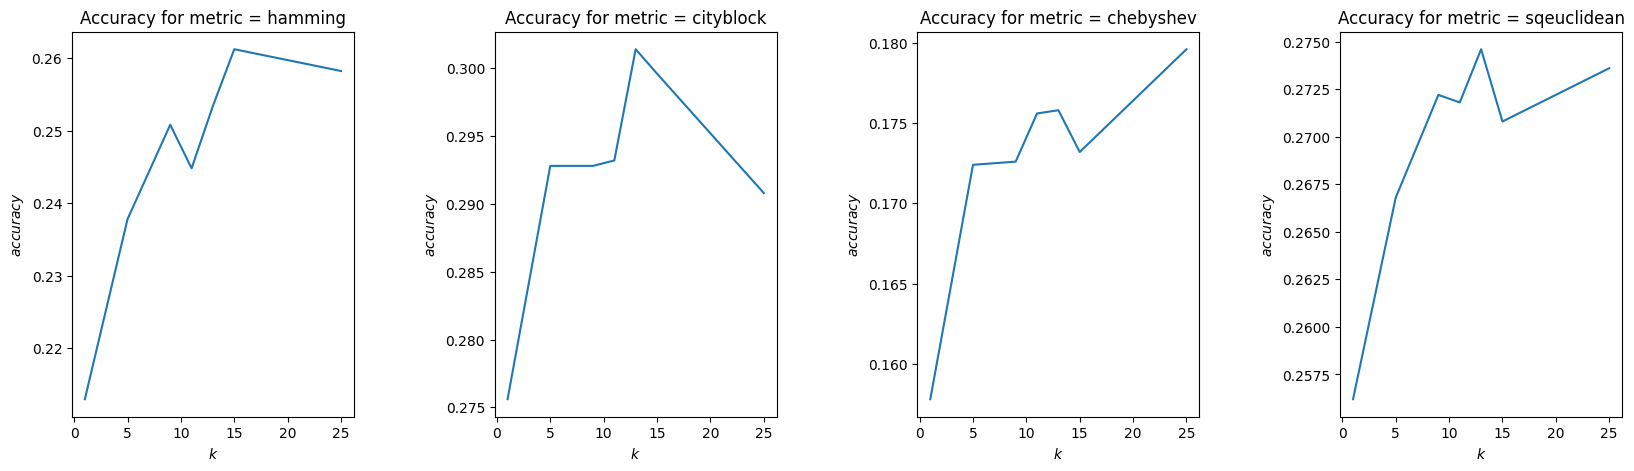

In [21]:
figure, axes = plt.subplots(1, len(data), figsize = (20, 5))
figure.subplots_adjust(wspace = 0.5)
for index, metric in enumerate(data):
    graph = axes[index]
    graph.set_title('Accuracy for metric = {}'.format(metric))
    graph.set_xlabel(r"$k$")
    graph.set_ylabel(r"$accuracy$")
    graph.plot(data[metric]['k'], data[metric]['score'])

Наибольшее среднее качество на кросс-валидации достигается при рассмотрении 13 ближайших соседей с использованием функции L1-расстояния. Для других функций расстояния наибольшее качество также наблюдается при рассмотрении около 13 соседей. Расстояние Чебышева показывает себя хуже остальных независимо от количества соседей.

In [22]:
def get_score(k, metric):
    model = kNearestNeighbors(k, metric).fit(X_train, y_train)
    return validate(model, X_val, y_val)

def plot_extended(metric):
    scores = [ get_score(k, metric) for k in tqdm.tqdm(PLOT_K) ]
    plt.figure(figsize = (9, 3))
    plt.title('Accuracy for metric = {}'.format(metric))
    plt.xlabel(r"$k$")
    plt.ylabel(r"$accuracy$")
    plt.plot(PLOT_K, scores)

100%|██████████| 50/50 [06:00<00:00,  7.21s/it]


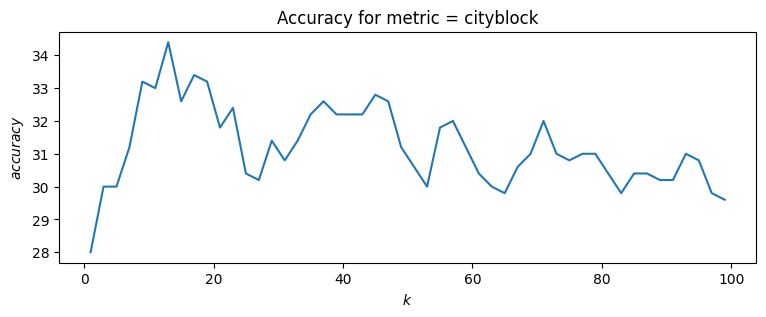

In [23]:
plot_extended('cityblock')

100%|██████████| 50/50 [04:40<00:00,  5.61s/it]


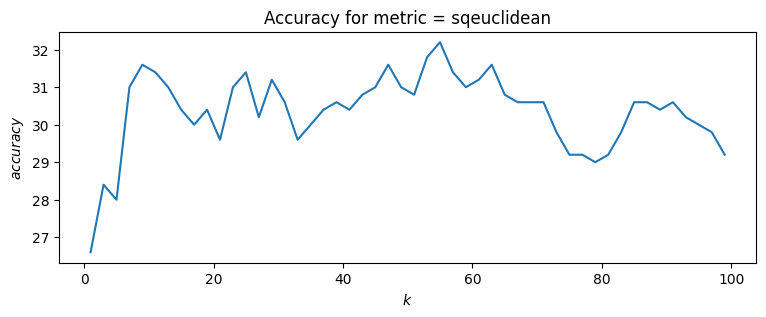

In [24]:
plot_extended('sqeuclidean')

100%|██████████| 50/50 [04:28<00:00,  5.38s/it]


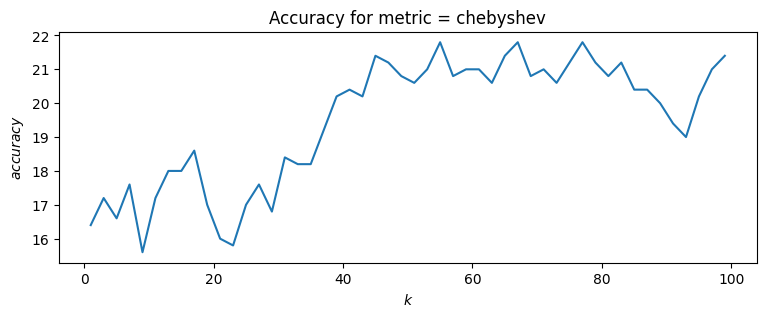

In [25]:
plot_extended('chebyshev')

100%|██████████| 50/50 [06:18<00:00,  7.57s/it]


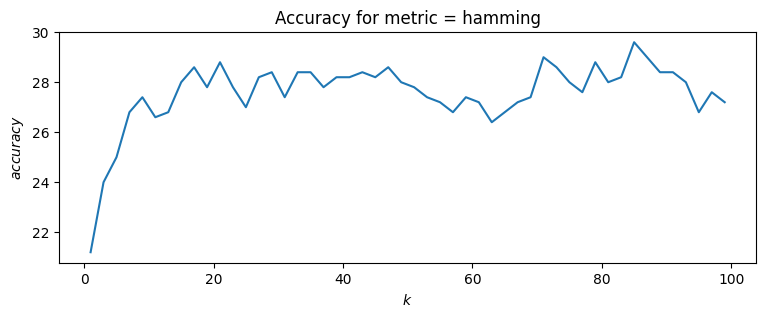

In [26]:
plot_extended('hamming')

Таким образом, с увеличением числа рассматриваемых соседей качество модели сначала быстро растет, а затем медленно уменьшается. Видно, что расстояния Чебышева и Хемминга, ожидаемо, показывают худшие результаты при любом значении параметра k. Наибольшее же качество, в подтверждение полученного кросс-валидацией результата, наблюдается при рассмотрении 13 ближайших соседей с использованием функции L1-расстояния. Евклидово расстояние также показывает себя достаточно хорошо, но проигрывает на несколько процентных пунктов.

## Evaluate time

In [27]:
%%time
model = kNearestNeighbors(best_k, best_metric).fit(X_train, y_train)

CPU times: user 90 µs, sys: 1 µs, total: 91 µs
Wall time: 96.6 µs


In [28]:
%%time
predictions = model.predict(X_val)

CPU times: user 7.22 s, sys: 39.5 ms, total: 7.26 s
Wall time: 7.32 s


In [29]:
print("Accuracy {:.3f}%".format(accuracy(predictions, y_val)))

Accuracy 34.400%


In [30]:
%%time
predictions = model.predict(X_test)

CPU times: user 2min 36s, sys: 513 ms, total: 2min 36s
Wall time: 2min 37s


In [31]:
print("Accuracy: {:.3f}%".format(accuracy(predictions, y_test)))

Accuracy: 31.800%


In [33]:
print(sklearn.metrics.classification_report(y_test, predictions, target_names = classes, digits = 3))

              precision    recall  f1-score   support

    airplane      0.373     0.526     0.436      1000
  automobile      0.629     0.132     0.218      1000
        bird      0.209     0.356     0.263      1000
         cat      0.302     0.083     0.130      1000
        deer      0.218     0.480     0.300      1000
         dog      0.428     0.183     0.256      1000
        frog      0.284     0.393     0.330      1000
       horse      0.535     0.193     0.284      1000
        ship      0.373     0.622     0.466      1000
       truck      0.591     0.212     0.312      1000

    accuracy                          0.318     10000
   macro avg      0.394     0.318     0.300     10000
weighted avg      0.394     0.318     0.300     10000



Таким образом, модель действительно обучается очень быстро, но её применение занимает достаточно много времени при относительно низком качестве на тестовой выборке: лишь 31.8% accuracy, 39.4% precision, 31.8% recall и 0.3 F1-score. Использование такой модели для продуктовых задач, скорее всего, не имеет смысла.